<a href="https://colab.research.google.com/github/Giuliano-1/COMP551/blob/main/A1_Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import math
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, PrecisionRecallDisplay
from abc import ABC, abstractmethod
from numpy.core.memmap import dtype
from zmq import NULL
from google.colab import data_table
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import skew
from scipy.stats import kurtosis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step 1 - Cleaning Section

In [ ]:
hepatitisData = np.genfromtxt("/content/drive/MyDrive/comp551/hepatitis.data", dtype = 'float',
                     encoding=None, delimiter=",")
#hepatitisData = hepatitisData.astype('float')
diabeticData = np.genfromtxt("/content/drive/MyDrive/comp551/messidor_features.arff", dtype = float,
                     encoding=None, delimiter=",")
#print(hepatitisData[:,0])
print(diabeticData)
print(diabeticData[0])

#nb_features_hep = len(hepatitisData[0])
#nb_hepatitis = len(hepatitisData)
#print(nb_features_hep)
#print(nb_hepatitis)
#nb_features_diab = len(diabeticData[0])
#nb_hepatitis = len(diabeticData)
#print(nb_features_diab)
#print(nb_hepatitis)

[[ 1.        1.       22.       ...  0.100025  1.        0.      ]
 [ 1.        1.       24.       ...  0.144414  0.        0.      ]
 [ 1.        1.       62.       ...  0.128548  0.        1.      ]
 ...
 [ 1.        0.       49.       ...  0.129843  0.        0.      ]
 [ 1.        1.       39.       ...  0.10669   1.        1.      ]
 [ 1.        1.        7.       ...  0.088957  0.        0.      ]]
[1.0000000e+00 1.0000000e+00 2.2000000e+01 2.2000000e+01 2.2000000e+01
 1.9000000e+01 1.8000000e+01 1.4000000e+01 4.9895756e+01 1.7775994e+01
 5.2709200e+00 7.7176100e-01 1.8632000e-02 6.8640000e-03 3.9230000e-03
 3.9230000e-03 4.8690300e-01 1.0002500e-01 1.0000000e+00 0.0000000e+00]


Removing Question Marks - replace with 0

In [ ]:
#Cleaning of the ?/nan put a 0 instead
#print(hepatitisData.shape)
#print(hepatitisData[0,:])
def remove_q_marks(dataset, nb_rows, nb_features):
  dataset2 = dataset
  for i in range(nb_rows):
    for j in range(nb_features):
      if(math.isnan(dataset2[i,j])):
        dataset2[i,j] = 0
   
  return dataset2

#hepatitisData2 = remove_q_marks(hepatitisData, len(hepatitisData), len(hepatitisData[0]))
#diabeticData2 = remove_q_marks(diabeticData, len(diabeticData), len(diabeticData[0]))
#print("Hep Data")
#print(hepatitisData2[0,:])
#print("Diab data:")
#print(diabeticData2)

Putting Class Column First

In [ ]:
#print('Pre:', diabeticData)
def put_class_first(dataset):
  reordered_dataset = dataset.copy()
  temp_class_array = dataset[:,-1]
  reordered_dataset[:,-1] = dataset[:,0]
  reordered_dataset[:,0] = temp_class_array
  
  return reordered_dataset

#diabeticData3 = put_class_first(diabeticData)
#print("Diab data:")
#print(diabeticData3)

Change Class to 0/1

In [ ]:
def class_to_boolean(dataset, nb_rows):
  dataset2 = dataset
  for i in range(nb_rows):
    dataset2[i,0]-=1

  return dataset2

#hepatitisData3 = class_to_boolean(hepatitisData, len(hepatitisData))
#print("Hep data:")
#print(hepatitisData3)

Supporting function

In [ ]:
def arr_contains(parr, pval):
  for i in range(len(parr)):
    if (parr[i]==pval):
      return True
  return False

Removing Lines with question marks

In [ ]:
#Cleaning of the ?/-1 removing line
def clean_data_removeline(dataset, nb_row, nb_cols):
  dataset2 = dataset
  i=0
  for i in range(nb_row):
    for j in range(nb_cols):
      if(dataset2[i,j]==-1):
        dataset2 = np.delete(dataset2, i, 0)
        if(i!=len(dataset2-1)):
          j=0
        else:
          break
    if(i==len(dataset2-1)):
       break
  return dataset2

#hepatitisData3 = clean_data_removeline(hepatitisData3, len(hepatitisData3), len(hepatitisData3[0]))
#diabeticData3 = clean_data_removeline(diabeticData, len(diabeticData), len(diabeticData[0]))
#print(hepatitisData3)
#print(len(hepatitisData3))
#print("diabetic data:")
#print(diabeticData3)
#print(len(diabeticData3))

Changing boolean from -1 to 1 from 1 to 2

In [ ]:
def boolean_offset(dataset, boolean_indices):
  cleaned_ds = dataset.copy()
  for i in boolean_indices:
    cleaned_ds[:,i]=cleaned_ds[:,i]-1
  return cleaned_ds

When removing rows with missing data points (corresponding to a patient) the dataset gets reduced from 1151 patients to 41, this is not advantageous given the model will not have enough datapoints to be well trained. Instead a methodology to go about picking important features, such as Random Forest is investigated.

Splitting with scikit

In [ ]:
def split(dataset):
  X = dataset[:,1:]
  y = dataset[:,0]
  return X, y

Feature Importance random forest

In [ ]:
def dim_reduction(X, n):
    #Dimensional reduction for diabetes dataset
    pca = PCA(n_components = n)
    principal_components = pca.fit_transform(X)
    variances = pca.explained_variance_ratio_
    return principal_components, variances

def rand_forrest(X, X_train, y_train, attributes):
    #Feature Importance random forest for hepatitis dataset
    a = attributes["dataset"]
    feature_names = [f"feature {i}" for i in range(X.shape[1])]
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr = std, ax = ax)
    ax.set_title(f'Feature importances using MDI for {a}')
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()

Scatter plot for Positive vs Negative classes

In [ ]:
def scatter_plot(dataset, ft1, ft2, attributes):
    ft1 = ft1 + 1
    ft2 = ft2 + 1
    a = attributes["dataset"]
    b = attributes[str(ft1 - 1)]
    c = attributes[str(ft2 - 1)]
    #Plotting the distribution between positive and negative classes
    positive_train = np.where(dataset[:,0] == 0)
    #print(positive_train)
    negative_train = np.where(dataset[:,0] == 1)
    #print(negative_train)
    plt.scatter(dataset[positive_train, ft1],dataset[positive_train, ft2],c='r', marker='o',label="Positive classes (Die)")
    plt.scatter(dataset[negative_train, ft1],dataset[negative_train, ft2],c='b', marker='o',label="Negative classes (Live)")
    plt.legend()
    plt.rcParams.update({'figure.figsize': (10, 8), 'figure.dpi': 100})
    plt.title(f'Distribution Between Positive & Negative Classes for {a}')
    plt.xlabel(f'{b}')
    plt.ylabel(f'{c}')
    plt.show()


# Step 2.1 - KNN class

In [ ]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

In [ ]:
class KNN:

    def __init__(self, K, dist_fn = manhattan): # CHANGE DISTANCE FUNCTION HERE
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = np.array(y, dtype=int)
        self.C = int(np.max(y) + 1)
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = int(x_test.shape[0])
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])
      
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        #print(self.C, num_test)
        y_prob = np.full((num_test, self.C), 0.0)
        for i in range(num_test):
            # print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # print(knns[i,:])
            #print(self.y[knns[i,:]])
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    def weighted_predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = int(x_test.shape[0])
      
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        #print(self.C, num_test)
        y_prob = np.full((num_test, self.C), 0.0)
        for i in range(num_test):
            # print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # print(knns[i,:])
            #print(self.y[knns[i,:]])
            tot_distance = 0
            class1_count = 0
            class2_count = 0
            #print(self.C)
            #print(knns[1,:])
            for j in range(0,self.K):
              tot_distance += distances[i, knns[i,j]]
              if (self.y[knns[i,j]] == 0):
                if(distances[i,knns[i,j]]!=0):
                  class1_count += 1/distances[i,knns[i,j]]
                else:
                  class1_count += 1
              elif (self.y[knns[i,j]] == 1):
                if(distances[i,knns[i,j]]!=0):
                  class2_count += 1/distances[i,knns[i,j]]
            
            y_prob[i,0] = class1_count
            y_prob[i,1] = class2_count
            #print(distances[i,:])
            #print(knns) 
            #print(y_prob)
            #print(tot_distance)
            y_prob[i,:] /= tot_distance #divide by total distance of all considered k-near training points
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        
        return y_prob, knns

    def evaluate_acc(self, y_test, y_pred):
        y_pred = np.array(y_pred, dtype=int)
        y_test = np.array(y_test, dtype=int)
        acc = np.sum(y_pred == y_test)/y_test.shape[0]
        return acc

    def misclassificate_rate(self, y_test, y_pred):
        misclass_rate = 1 - self.evaluate_acc(y_test, y_pred)
        return misclass_rate

Decision Boundaries

In [ ]:
def decision_boundary(model, X, y, X_test, y_test, X_train, y_train, ft1, ft2, attributes, max_k): 

    f1 = ft1
    f2 = ft2
    a = attributes["dataset"]
    b = attributes[str(ft1)]
    c = attributes[str(ft2)]
    #print(X)
    x0v = np.linspace(np.min(X[:,f1]), np.max(X[:,f1]), 200)
    x1v = np.linspace(np.min(X[:,f2]), np.max(X[:,f2]), 200)
    #print(x0v)

    # to features values as a mesh  
    x0, x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T
    #print(x_all)

    C = int(np.max(y)+1)

    for k in range(1, max_k):
        print("K :", k)
        model_current = model(k)

        y_train_prob = np.zeros((y_train.shape[0], C))
        y_train_prob[np.arange(y_train.shape[0]), np.int_(y_train)] = 1

        y_prob, knns = model_current.fit(X_train, np.int_(y_train)).predict(X_test)
        y_pred = np.argmax(y_prob,axis=-1)    
        correct = (y_test == y_pred)
        incorrect = np.logical_not(correct)    
        
        y_pred = np.argmax(y_prob,axis=-1)
        accuracy = model_current.evaluate_acc(y_test, y_pred) #np.sum(y_pred == y_test)/y_test.shape[0]
        acc = f'test accuracy: {accuracy*100:.1f}'
        print(acc)
      
        X_train2D = np.delete(X_train, slice(2,19), 1)
        #print(X_train2D)
        #print(X_train.shape)
        #print(X_train2D.shape)
        X_train_2D_temp = np.array([X_train[:,f1], X_train[:, f2]]).T
        X_train2D = X_train_2D_temp
        #print(X_train2D.shape)
        #to get class probability of all the points in the 2D grid
        y_prob_all, _ = model_current.fit(X_train2D, np.int_(y_train)).predict(x_all)
        B = np.full((y_prob_all.shape[0], 1), 0.0)
        y_prob_all = np.append(y_prob_all, B, axis=1)

        B = np.full((y_train_prob.shape[0], 1), 0.0)
        y_train_prob = np.append(y_train_prob, B, axis=1)
        #print(model.C)
        #print(y_prob_all.shape)
        #print(y_train_prob.shape)
        y_pred_all = np.zeros_like(y_prob_all)
        y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1    

        plt.scatter(X_train2D[:, 0], X_train2D[:,1], c=y_train_prob, marker='o', alpha=1)
        plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=.05)
        plt.title(f'KNN Decision Boundary for {a} - {acc} - K =' + str(k))
        plt.xlabel(f'{b}')
        plt.ylabel(f'{c}')
        #if (k==10):
          #plt.savefig(f'decision_boundary_K={k}_Standardized_Weighted_{a}.png')
        plt.show() 


KNN hyperparamter 

In [ ]:
def hyper_parameter_KNN(model, arg_p, arg_x_train, arg_y_train, arg_x_val, arg_y_val, attributes):
  a = attributes["dataset"]
  model_choices = []
  valid_acc = []
  max_p = arg_p
  test_accuracy = np.full((max_p-1), 0.0)

  X_train_tr, y_train_tr = arg_x_train, arg_y_train
  X_train_va, y_train_va = arg_x_val, arg_y_val

  best_acc_test = 0
  
  for hyper_p in range(1,max_p): #Can be changed 
      model = KNN(hyper_p)

      y_train_va_prob,_ = model.fit(X_train_tr, y_train_tr).predict(X_train_va)
      y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)

      accuracy = model.evaluate_acc(y_train_va, y_train_va_pred) #accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
      model_choices.append(hyper_p)
      valid_acc.append(accuracy)

      if(accuracy>best_acc_test):
        best_acc_test = accuracy
        best_test_k = hyper_p

  # use the best K to predict test data
  best_valid_K = model_choices[valid_acc.index(max(valid_acc))]#
  knn = KNN(K=best_valid_K)
  y_test_prob,_ = knn.fit(X_train, y_train).predict(X_test)
  y_test_pred = np.argmax(y_test_prob, axis=-1)
  test_accuracy = knn.evaluate_acc(y_test, y_test_pred) 
  print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

  #print(model_choices)
  #print(valid_acc)
  #print(test_accuracy)

  plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
  plt.plot(best_test_k, test_accuracy, marker='*', color='red', label='testing')
  plt.title(f'KNN Hyperparameter for Standardized and Weighted {a}')
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  #plt.savefig(f'hyper-param_Standardized_Weighted_{a}')
  plt.show()
  return best_valid_K

In [ ]:
# further split the training data into 50% training and 50% validation
#X_train_tr, y_train_tr = X_train[:int(X_train.shape[0]/2)], y_train[:int(y_train.shape[0]/2)]
#X_train_va, y_train_va = X_train[int(X_train.shape[0]/2):], y_train[int(y_train.shape[0]/2):]
#modelKNN = KNN(K=1)
#print(X_train_va.shape)
#print(y_train_va.shape)

#hyper_parameter_KNN(KNN, 11, X_train_tr, y_train_tr, X_train_va, y_train_va)

ROC/AUROC Curve

In [ ]:
def roc_plot(model, K_parameter, X_train, X_test, y_train, y_test, attributes): 
    a = attributes["dataset"]
    knn = model(K_parameter)
    y_test_prob,_ = knn.fit(X_train, y_train).predict(X_test)
    y_test_pred = np.argmax(y_test_prob,axis=-1)
    #print(y_test_pred.shape)
    #print(y_test.shape)
    fpr, tpr, threshholds = roc_curve(y_test, y_test_prob[:,1], pos_label = None)
    #print(fpr)
    #print(tpr)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    plt.plot(fpr, tpr, "b-", lw=2.5, label=f'AUROC = {roc_auc}')
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
    #plt.axline((0,0), (1,1), linestyle="--", lw=1.5, color='c')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC in prediciting for unstandardized {a} using Manhattan')
    plt.legend(loc="best")
    #plt.savefig(f'ROC_K={K_parameter}_{a}_manhattan')
    plt.show()

def roc_plot_DT(model, depth_parameter, X_train, X_test, y_train, y_test, attributes): 
    a = attributes["dataset"]
    dt = model(depth_parameter)
    y_test_prob = dt.fit(X_train, y_train).predict(X_test)
    y_test_pred = np.argmax(y_test_prob,axis=-1)
    #print(y_test_pred.shape)
    #print(y_test.shape)
    fpr, tpr, threshholds = roc_curve(y_test, y_test_prob[:,1], pos_label = None)
    #print(fpr)
    #print(tpr)
    roc_auc = roc_auc_score(y_test, y_test_pred)

    plt.plot(fpr, tpr, "b-", lw=2.5, label=f'AUROC = {roc_auc}')
    plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
    #plt.axline((0,0), (1,1), linestyle="--", lw=1.5, color='c')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC in prediciting for {a}')
    plt.legend(loc="best")
    plt.show()
    #plt.savefig('DT_ROC_hepatitis.png')
 
#roc_plot(KNN, 14, X_train, X_test, y_train, y_test)

Precision Recall/AUPRC Curve

In [ ]:
def prc_plot(model, K_parameter, X_train, X_test, y_train, y_test, attributes):
  a = attributes["dataset"]
  knn = model(K_parameter)
  y_test_prob,_ = knn.fit(X_train, y_train).predict(X_test)
  y_test_pred = np.argmax(y_test_prob, axis=-1)
  precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob[:,1])
  prc_plot = PrecisionRecallDisplay(precision = precision, recall = recall)
  auprc = sklearn.metrics.auc(recall, precision)
  prc_plot.plot()
  
  #plt.plot(precision, recall, "b-", lw=2.5, label="AUPRC = 0.25f", %auprc)
  #plt.xlabel('Recall')
  #plt.ylabel('Precision')
  #plt.title(f'PRC in predicting for {a}')
  #plt.legend(loc="best")
  #plt.show()

def prc_plot_DT(model, K_parameter, X_train, X_test, y_train, y_test, attributes):
  a = attributes["dataset"]
  DT = model(K_parameter)
  y_test_prob = DT.fit(X_train, y_train).predict(X_test)
  y_test_pred = np.argmax(y_test_prob, axis=-1)
  precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob[:,1])
  prc_plot = PrecisionRecallDisplay(precision = precision, recall = recall)
  auprc = sklearn.metrics.auc(recall, precision)
  prc_plot.plot()
  #plt.savefig('DT_PCR_hepatitis.png')

  #plt.plot(precision, recall, "b-", lw=2.5, label="AUPRC = 0.25f", %auprc)
  #plt.xlabel('Recall')
  #plt.ylabel('Precision')
  #plt.title(f'PRC in predicting for {a}')
  #plt.legend(loc="best")
  #plt.show()

Choose Dataset

In [ ]:
# Initial cleaning of the working dataset
switch = 1 #Set equal to 0 for the hepatitis dataset or 1 for the diabetis dataset
if (switch == 0):
    working_dataset = hepatitisData.copy()
    working_dataset_cleaned = remove_q_marks(working_dataset, len(working_dataset), len(working_dataset[0]))
    working_dataset_cleaned = boolean_offset(working_dataset_cleaned, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
    working_dataset_cleaned = class_to_boolean(working_dataset_cleaned, len(working_dataset_cleaned))
    attributes = {"dataset": "Hepatitis Domain", "0": "AGE", "1": "SEX", "2": "STEROID", "3": "ANTIVIRALS", "4": "FATIGUE", "5": "MALAISE", "6": "ANOREXIA", "7": "LIVER BIG", "8": "LIVER FIRM", "9": "SPLEEN PALPABLE", "10": "SPIDERS", "11": "ASCITES", "12": "VARICES", "13": "BILIRUBIN", "14": "ALK PHOSPHATE", "15": "SGOT", "16": "ALBUMIN", "17": "PROTIME", "18": "HISTOLOGY"}
elif (switch == 1):
    working_dataset = diabeticData.copy()
    working_dataset_cleaned = remove_q_marks(working_dataset, len(working_dataset), len(working_dataset[0]))
    working_dataset_cleaned = put_class_first(working_dataset_cleaned)
    attributes = attributes = {"dataset": "Messidor - Diabetic Retinopathy", "0": "Feature 0", "1": "Feature 1", "2": "Feature 2", "3": "Feature 3", "4": "Feature 4", "5": "Feature 5", "6": "Feature 6", "7": "Feature 7", "8": "Feature 8", "9": "Feature 9", "10": "Feature 10", "11": "Feature 11", "12": "Feature 12", "13": "Feature 13", "14": "Feature 14", "15": "Feature 15", "16": "Feature 16", "17": "Feature 17", "18": "Feature 18"}

X, y = split(working_dataset_cleaned)
y = np.array(y, dtype = int)
#X, variances = dim_reduction(X, 2) # UNCOMMENT HERE TO TURN ON PCA DIM REDUCTION
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42, shuffle=True) # Used a 25% split as the standard

principle_component, variances = dim_reduction(X, 2)



Basic Statistics

In [ ]:
statistics_data = np.full([len(X[0]), 4], 0.0)
outliers = np.full([len(X[0]), 1], 0.0)
for i in range(len(X[0])):
  statistics_data[i, 0]= X[:, i].mean()
  statistics_data[i, 1]= X[:, i].std()
  statistics_data[i, 2]= skew(X[:, i])
  statistics_data[i, 3]= kurtosis(X[:, i])
  outliers[i] = (np.max(X[:,i])- X[:, i].mean())/X[:, i].std()

#print(statistics_data)
#print(outliers)

KNN Main

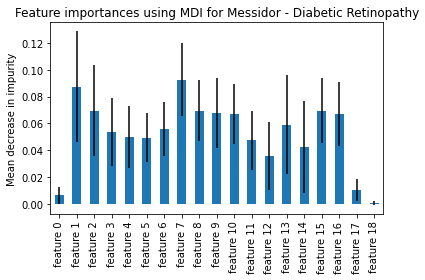

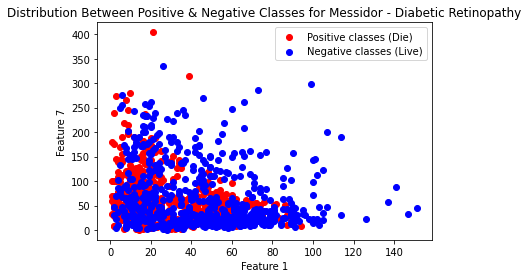

In [ ]:
#Working with unstandardized features

#Run random forrest to determine most important features
rand_forrest(X, X_train, y_train, attributes)

#Features to be plotted to compare negative vs positive classes
feature1 = 1 # FOR PCA CHANGE TO 0 and 1
feature2 = 7
scatter_plot(working_dataset_cleaned, feature1, feature2, attributes)

In [ ]:
#Main Experiments 

decision_boundary(KNN, X, y, X_test, y_test, X_train, y_train, feature1, feature2, attributes, max_k = 18)

#Further split the training data into 50% training and 50% validation
X_train_tr, y_train_tr = X_train[:int(X_train.shape[0]/2), :], y_train[:int(y_train.shape[0]/2)]
X_train_va, y_train_va = X_train[int(X_train.shape[0]/2):, :], y_train[int(y_train.shape[0]/2):]
#print(X_train_va.shape)
#print(y_train_va.shape)

best_K = hyper_parameter_KNN(KNN, 20, X_train_tr, y_train_tr, X_train_va, y_train_va, attributes)
roc_plot(KNN, 6, X_train, X_test, y_train, y_test, attributes)
prc_plot(KNN, 6, X_train, X_test, y_train, y_test, attributes)

In [ ]:
#Working with standardized features
X_train_mod = X_train.copy()
X_test_mod = X_test.copy()
X_mod = X.copy()
#X_train_mod[:,0] = X_train_mod[:,0] * 100
##X_test_mod[:,0] = X_test_mod[:,0] * 100
diab_boolean_columns = np.array([0, 1, 18])
hepit_boolean_columns = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,18])
for d in range(X_train.shape[1]):
    if (switch==0 & arr_contains(hepit_boolean_columns, d)):
      pass
    elif(switch==1 & arr_contains(diab_boolean_columns, d)):
      pass
    if(X_train_mod[:,d].std()!=0):
       X_train_mod[:,d] = (X_train_mod[:,d] - X_train_mod[:,d].mean())/X_train_mod[:,d].std()
    if(X_test_mod[:,d].std()!=0):
       X_test_mod[:,d] = (X_test_mod[:,d] - X_test_mod[:,d].mean())/X_test_mod[:,d].std()
    if(X_mod[:,d].std()!=0):
       X_mod[:,d] = (X_mod[:,d] - X_mod[:,d].mean())/X_mod[:,d].std()
#print(X_mod)

In [ ]:
#Main Experiments Standardized
#print(X)
decision_boundary(KNN, X_mod, y, X_test_mod, y_test, X_train_mod, y_train, feature1, feature2, attributes, max_k = 20)

#Further split the training data into 50% training and 50% validation
X_train_tr_mod, y_train_tr = X_train_mod[:int(X_train_mod.shape[0]/2), :], y_train[:int(y_train.shape[0]/2)]
X_train_va_mod, y_train_va = X_train_mod[int(X_train_mod.shape[0]/2):, :], y_train[int(y_train.shape[0]/2):]
#print(X_train_va_mod.shape)
#print(y_train_va.shape)
plt.figure(1)
best_K = hyper_parameter_KNN(KNN, 11, X_train_tr_mod, y_train_tr, X_train_va_mod, y_train_va, attributes)
plt.figure(2)
roc_plot(KNN, 6, X_train_mod, X_test_mod, y_train, y_test, attributes)
prc_plot(KNN, 6, X_train_mod, X_test_mod, y_train, y_test, attributes)

KNN Main for the Diabetes dataset

K-fold 

[[ 1.       20.       18.       ...  0.089936  1.        1.      ]
 [ 1.       44.       41.       ...  0.081739  1.        1.      ]
 [ 1.       26.       26.       ...  0.098208  0.        1.      ]
 ...
 [ 1.       48.       47.       ...  0.133066  0.        1.      ]
 [ 1.       18.       18.       ...  0.096549  1.        1.      ]
 [ 1.        5.        5.       ...  0.096821  1.        1.      ]]
[0 0 1 ... 0 1 0]


Text(0, 0.5, 'True Positive Rate')

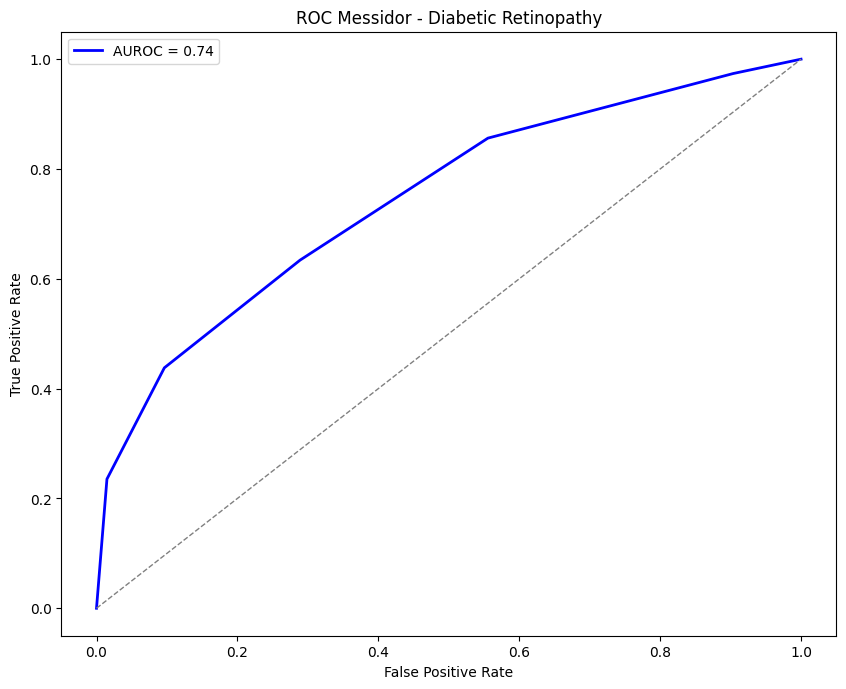

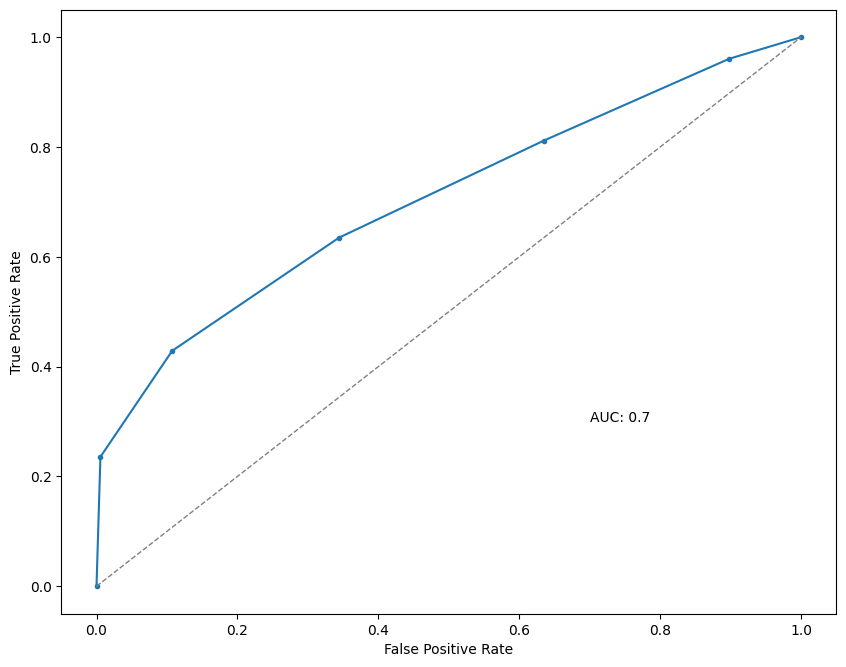

In [ ]:
knn = KNeighborsClassifier()
print(X_train)
knn.fit(X_train, y_train)
# column 0 is healthy
# column 1 is cancer
y_test_prob = knn.predict_proba(X_test)[:,1]
#y_test = y_test+1
#print(y_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.clf()
plt.plot(fpr, tpr, "b-", lw=2, label="AUROC = %0.2f"%roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC {attributes["dataset"]}')
plt.legend(loc="best")
#plt.savefig("roc_curve.png",bbox_inches='tight', dpi=300)

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return y, yh

knn = KNeighborsClassifier()

true_labels,pred_scores = cross_validate(knn, X, y)

print(true_labels)
fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.savefig('prostate_cancer_knn_crossvalid_roc.eps')

In [ ]:
#Main Experiments
#Testing PCA 
print(X_train.shape)
G, variances = dim_reduction(X_train, 2)
print(G.shape)
print(G[:,1])
print(variances)

(863, 19)
(863, 2)
[-3.50007551e+01  6.11751587e+01 -5.41802747e+01  9.99472234e+00
 -4.67497199e+01  5.41218252e+00  4.34299969e+01 -4.61955385e+01
  3.36632321e+01 -5.29272760e+00 -2.15627029e+01  1.81072686e+01
  3.85943737e+01 -4.31238917e+01 -1.24405154e+01  2.73504699e+01
 -7.20794659e+01  1.67673578e+01  1.56656739e+01 -6.86361411e+00
 -4.61599345e+00  2.48490325e+00 -7.28143168e+00  3.98839532e+01
 -3.80390048e+00 -5.54594387e+01 -5.48201489e+01  1.11833063e+01
 -6.71180515e+01  2.03036220e+01 -5.08867442e+01  1.43400254e+01
  3.50911945e+01 -5.37096730e+00  3.18276010e+01 -5.03986353e-01
 -4.15806357e+01 -1.44186267e+01  1.02576873e+00 -2.64099562e+01
 -4.00175860e+01 -3.16596230e+01  2.47714455e+01  7.10064473e+00
  4.02364045e+01 -6.53177998e+01 -2.81546378e+01 -3.74329724e+01
 -2.86866260e+01 -6.61063440e+00 -7.41710974e+01 -3.91213450e+01
 -7.22353504e+01 -5.10583071e+01  3.58302004e+01  4.36414379e+01
  9.97974409e-01 -4.43280436e+01 -3.91517969e+01  7.09574222e+01
  7.06

# Step 2.2 - Decision Tree

Initializaiton of leafs (Nodes)

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels   
            self.labels = np.array(self.labels, dtype = int)                  #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

Greedy Algorithm 

In [ ]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

Cost Functions

In [ ]:
def cost_misclassification(labels):
    labels = np.array(labels, dtype = int)
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))        

DT Class

In [ ]:
class DecisionTree:
  def __init__(self, max_depth, num_classes=None, cost_fn=cost_entropy, min_leaf_instances=1): #CHANGE COST FUNCTION HERE
      self.max_depth = max_depth      #maximum dept for termination 
      self.root = None                #stores the root of the decision tree 
      self.cost_fn = cost_fn          #stores the cost function of the decision tree 
      self.num_classes = num_classes  #stores the total number of classes
      self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
  def fit(self, data, labels):
      self.data = data
      self.labels = labels
      if self.num_classes is None:
          self.num_classes = np.max(labels) + 1
      #below are initialization of the root of the decision tree
      self.root = Node(np.arange(data.shape[0]), None)
      self.root.data = data
      self.root.labels = labels
      self.root.num_classes = self.num_classes
      self.root.depth = 0
      #to recursively build the rest of the tree
      self._fit_tree(self.root)
      return self

  def _fit_tree(self, node):
      #This gives the condition for termination of the recursion resulting in a leaf node
      if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
          return
      #greedily select the best test by minimizing the cost
      cost, split_feature, split_value = greedy_test(node, self.cost_fn)
      #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
      if np.isinf(cost):
          return
      #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
      #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
      test = node.data[node.data_indices,split_feature] <= split_value
      #store the split feature and value of the node
      #print('split feature', split_feature)
      node.split_feature = split_feature
      node.split_value = split_value
      #define new nodes which are going to be the left and right child of the present node
      left = Node(node.data_indices[test], node)
      right = Node(node.data_indices[np.logical_not(test)], node)
      #recursive call to the _fit_tree()
      self._fit_tree(left)
      self._fit_tree(right)
      #assign the left and right child to present child
      node.left = left
      node.right = right

  def predict(self, data_test):
      class_probs = np.zeros((data_test.shape[0], self.num_classes))
      for n, x in enumerate(data_test):
          node = self.root
          #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
          while node.left:
              if x[node.split_feature] <= node.split_value:
                  node = node.left
              else:
                  node = node.right
          #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
          class_probs[n,:] = node.class_prob
      return class_probs

Boundary Decision


In [ ]:
def boundary_decision_DT(px_train, py_train, ft1, ft2, attributes, num_classes, max_d):

    f1 = ft1
    f2 = ft2
    a = attributes["dataset"]
    b = attributes[str(ft1)]
    c = attributes[str(ft2)]

    #print(px_train.shape)
    x_train = np.array([px_train[:, f1], px_train[:,f2]]).T
    y_train = py_train
    x0v = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 200)
    x1v = np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), 200)
    x0,x1 = np.meshgrid(x0v, x1v)
    x_all = np.vstack((x0.ravel(),x1.ravel())).T

    for i in range(1, max_d):
      print(i)
      model = DecisionTree(max_depth=i)
      y_train_prob = np.zeros((y_train.shape[0], num_classes))
      y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
      
      y_prob_all = model.fit(x_train, y_train).predict(x_all)
      B = np.full((y_train_prob.shape[0], 1), 0.0)
      y_train_prob = np.append(y_train_prob, B, axis=1)
      B = np.full((y_prob_all.shape[0], 1), 0.0)
      y_prob_all = np.append(y_prob_all, B, axis=1)
      fig= plt.figure()
      plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
      plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.05)
      plt.title(f'DT Decision Boundary for {a} - Depth =' + str(i))
      plt.xlabel(f'{b}')
      plt.ylabel(f'{c}')
      plt.show()

Hyper Parameter for DT

In [ ]:
def hyper_param_DT(x_train, y_train, x_test, y_test, attributes, max_d):
  # further split the training data into 50% training and 50% validation
  X_train_tr, y_train_tr = x_train[:int(x_train.shape[0]/2)], y_train[:int(y_train.shape[0]/2)]
  X_train_va, y_train_va = x_train[int(x_train.shape[0]/2):], y_train[int(y_train.shape[0]/2):]

  a = attributes["dataset"]
  model_choices=[]
  train_acc = []
  valid_acc = []

  n_train = y_train_tr.shape[0]
  n_valid = y_train_va.shape[0]

  for i in range(1, max_d):
      dt = DecisionTree(max_depth=i)

      y_train_tr_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_tr)
      y_train_tr_pred = np.argmax(y_train_tr_prob, axis=-1)
      acc_tr = np.sum(y_train_tr_pred == y_train_tr)/n_train

      y_train_va_prob = dt.fit(X_train_tr, y_train_tr).predict(X_train_va)
      y_train_va_pred = np.argmax(y_train_va_prob, axis=-1)
      acc_va = np.sum(y_train_va_pred == y_train_va)/n_valid

      model_choices.append(i)
      train_acc.append(acc_tr)
      valid_acc.append(acc_va)

  best_depth = model_choices[valid_acc.index(max(valid_acc))]
  dt = DecisionTree(max_depth=best_depth)
  y_test_prob = dt.fit(x_train, y_train).predict(x_test)
  y_test_pred = np.argmax(y_test_prob, axis=-1)
  test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
  print(f'best depth = {best_depth}, test accuracy = {test_accuracy}')
  fig = plt.figure()
  plt.plot(model_choices, train_acc, marker='d', color='black', label='training')
  plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
  plt.plot(best_depth, test_accuracy, marker='*', color='red', label='testing')
  plt.title(f'DT Hyperparameter for {a}')
  plt.xlabel("Tree depth")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.plot()





Main for DT

(863, 19)
1


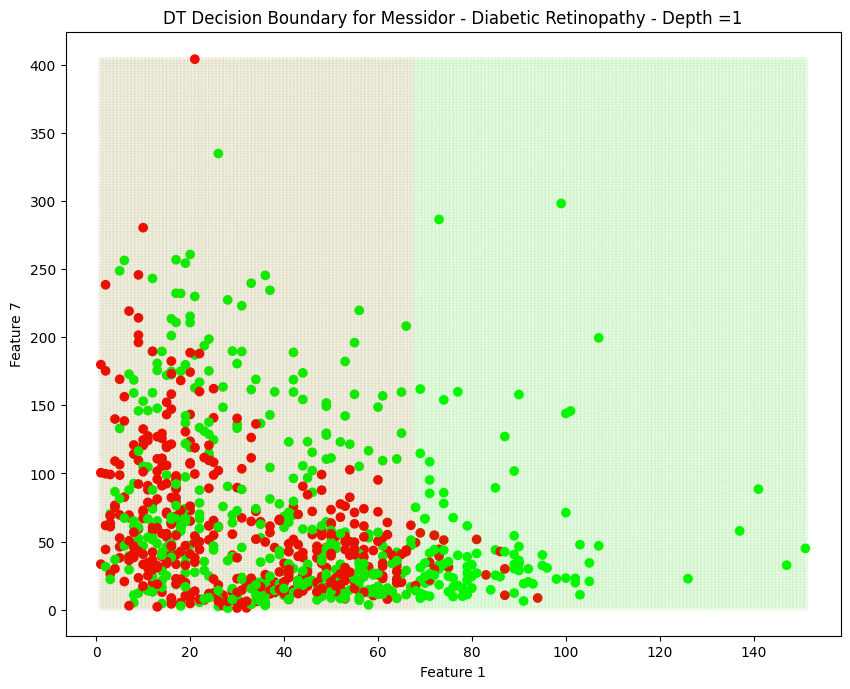

2


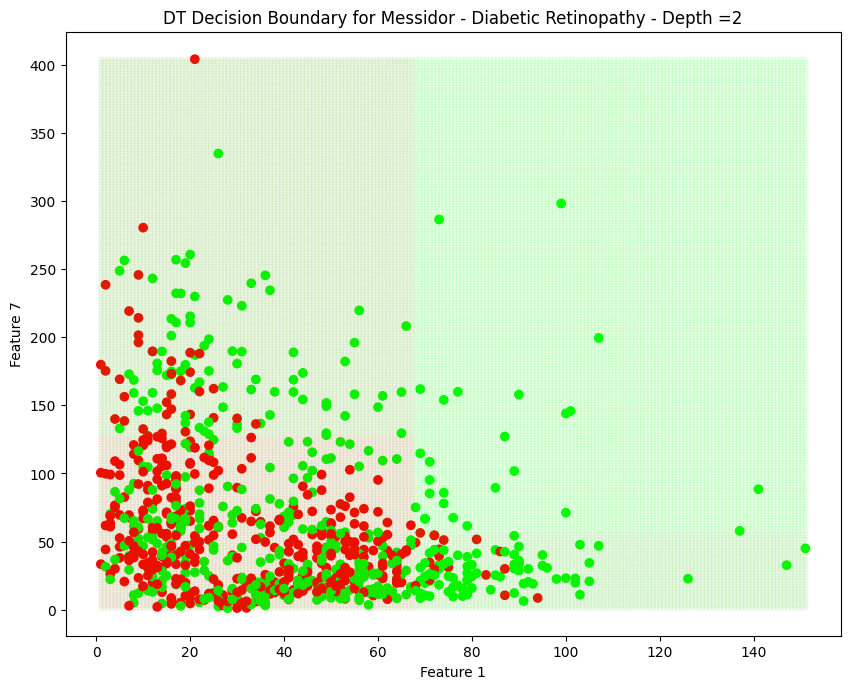

3


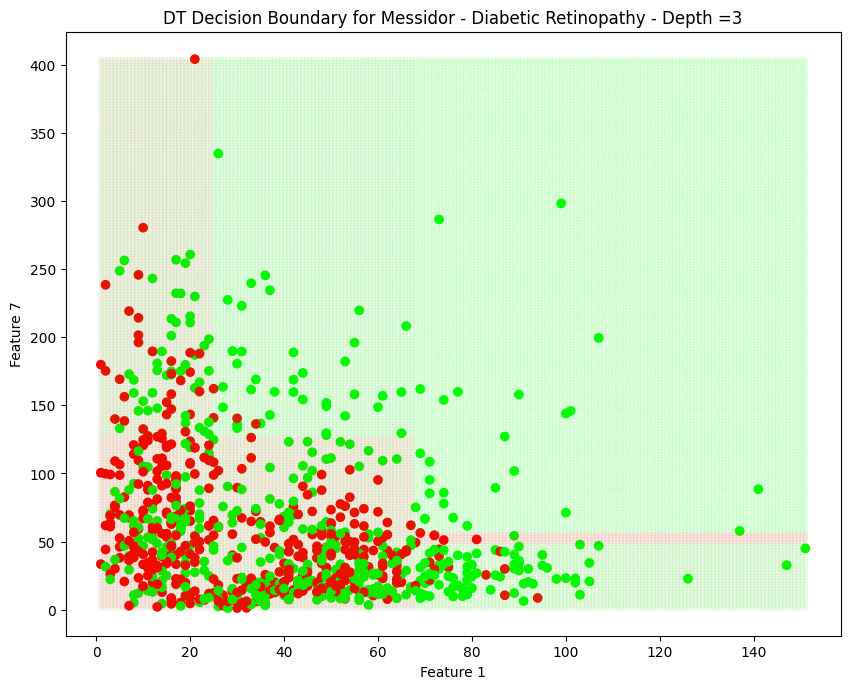

4


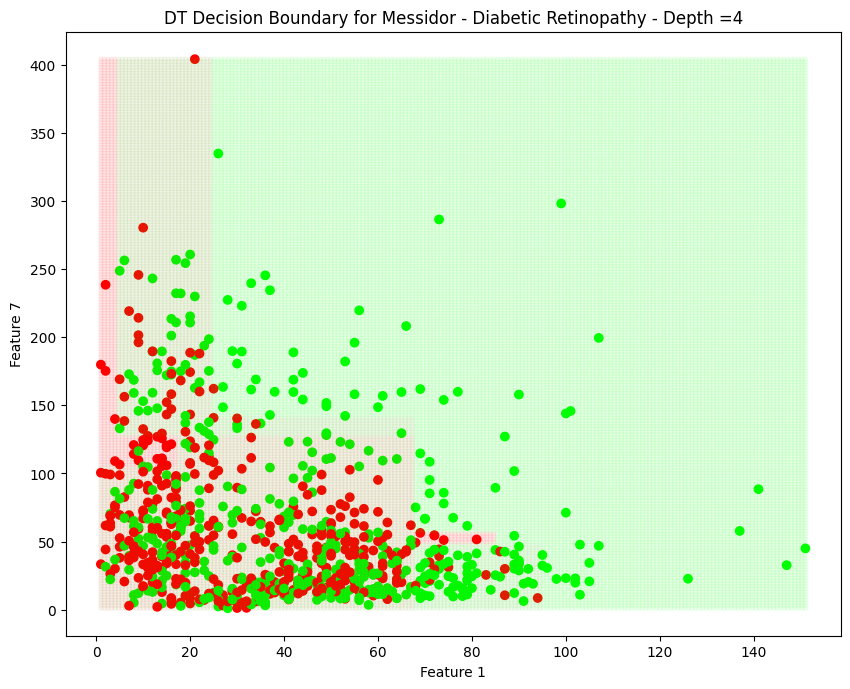

In [ ]:
#Main Experiments 
print(X_train.shape)

boundary_decision_DT(X_train, y_train, feature1, feature2, attributes, num_classes=2, max_d=5)

#Further split the training data into 50% training and 50% validation
X_train_tr, y_train_tr = X_train[:int(X_train.shape[0]/2), :], y_train[:int(y_train.shape[0]/2)]
X_train_va, y_train_va = X_train[int(X_train.shape[0]/2):, :], y_train[int(y_train.shape[0]/2):]
#print(X_train_va.shape)
#print(y_train_va.shape)

best depth = 13, test accuracy = 0.6180555555555556


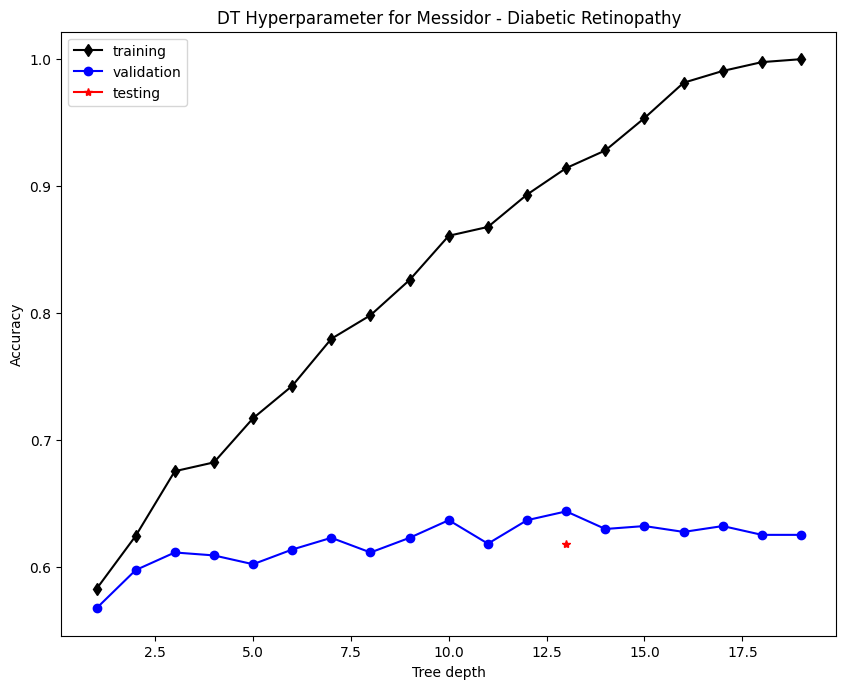

In [ ]:
best_D = hyper_param_DT(X_train, y_train, X_test, y_test, attributes, max_d=20)
DT = DecisionTree(max_depth =1)
DT.fit(X_train, y_train)

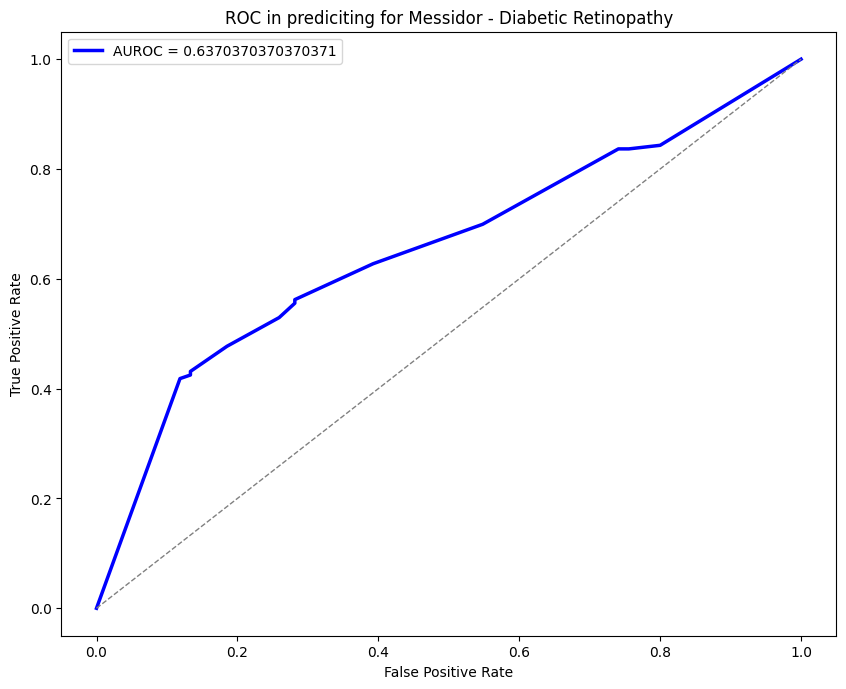

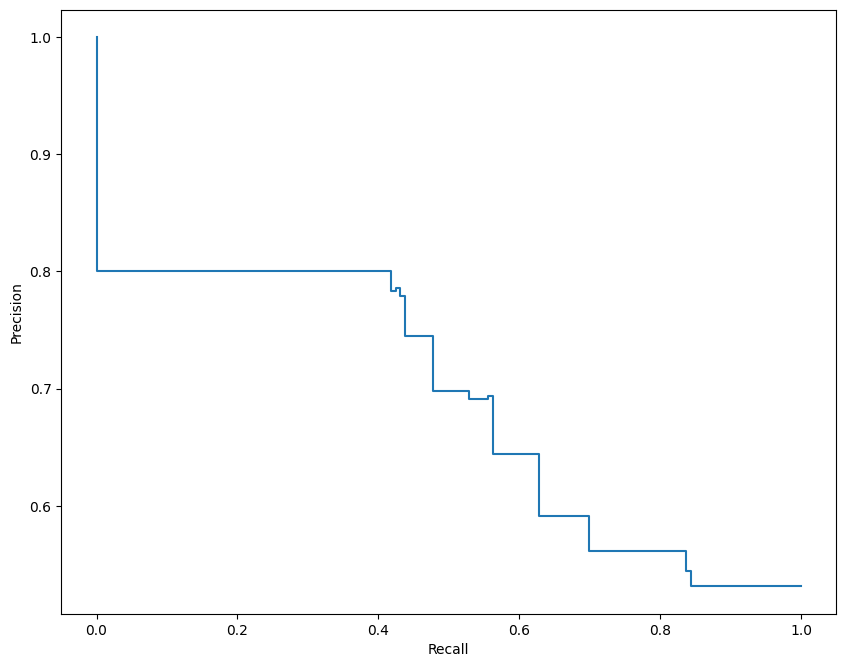

In [ ]:
roc_plot_DT(DecisionTree, 10, X_train, X_test, y_train, y_test, attributes)
prc_plot_DT(DecisionTree, 10, X_train, X_test, y_train, y_test, attributes)

[[ 1.       20.       18.       ...  0.089936  1.        1.      ]
 [ 1.       44.       41.       ...  0.081739  1.        1.      ]
 [ 1.       26.       26.       ...  0.098208  0.        1.      ]
 ...
 [ 1.       48.       47.       ...  0.133066  0.        1.      ]
 [ 1.       18.       18.       ...  0.096549  1.        1.      ]
 [ 1.        5.        5.       ...  0.096821  1.        1.      ]]
[0 0 1 ... 0 1 0]


Text(0, 0.5, 'True Positive Rate')

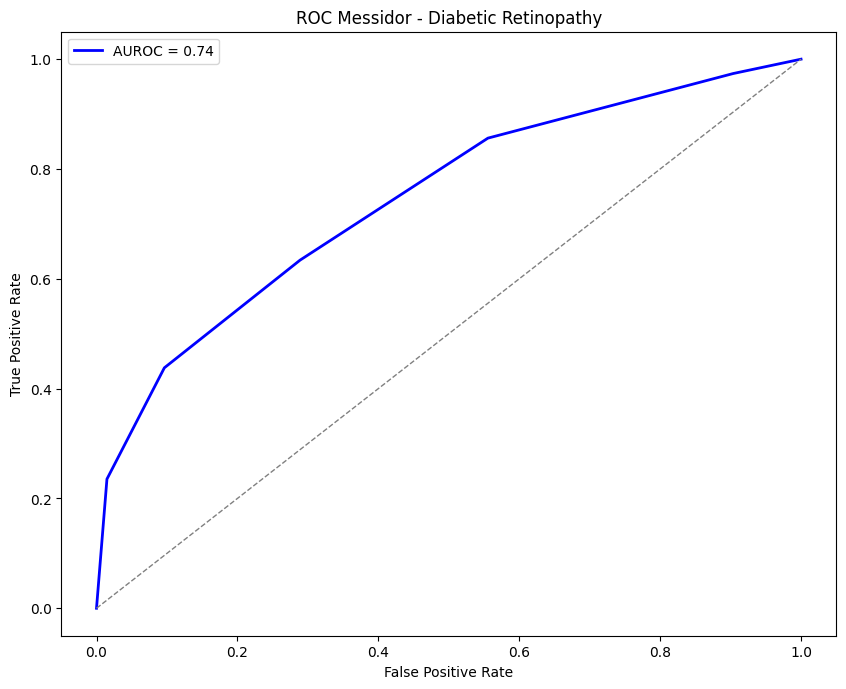

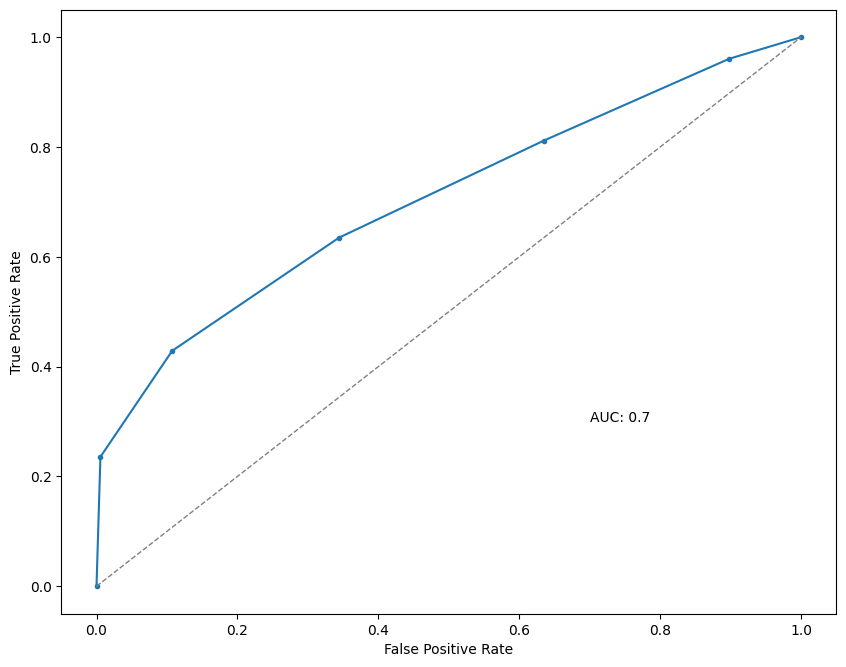

In [ ]:
knn = KNeighborsClassifier()
print(X_train)
knn.fit(X_train, y_train)
# column 0 is healthy
# column 1 is cancer
y_test_prob = knn.predict_proba(X_test)[:,1]
#y_test = y_test+1
#print(y_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.clf()
plt.plot(fpr, tpr, "b-", lw=2, label="AUROC = %0.2f"%roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC {attributes["dataset"]}')
plt.legend(loc="best")
#plt.savefig("roc_curve.png",bbox_inches='tight', dpi=300)

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return y, yh

knn = KNeighborsClassifier()

true_labels,pred_scores = cross_validate(knn, X, y)

print(true_labels)
fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.savefig('prostate_cancer_knn_crossvalid_roc.eps')

K-fold 

[[ 1.       20.       18.       ...  0.089936  1.        1.      ]
 [ 1.       44.       41.       ...  0.081739  1.        1.      ]
 [ 1.       26.       26.       ...  0.098208  0.        1.      ]
 ...
 [ 1.       48.       47.       ...  0.133066  0.        1.      ]
 [ 1.       18.       18.       ...  0.096549  1.        1.      ]
 [ 1.        5.        5.       ...  0.096821  1.        1.      ]]
[0 0 1 ... 0 1 0]


Text(0, 0.5, 'True Positive Rate')

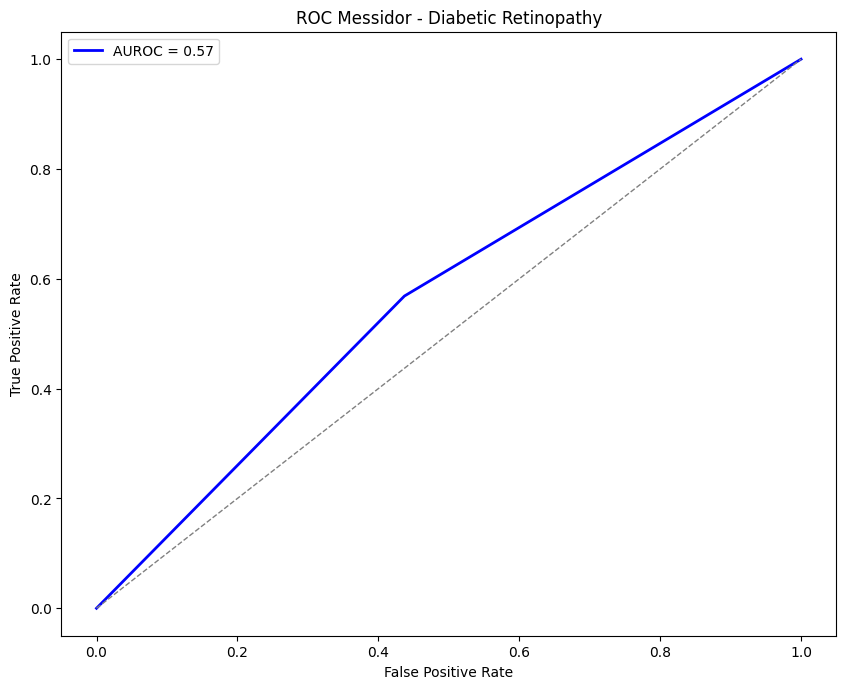

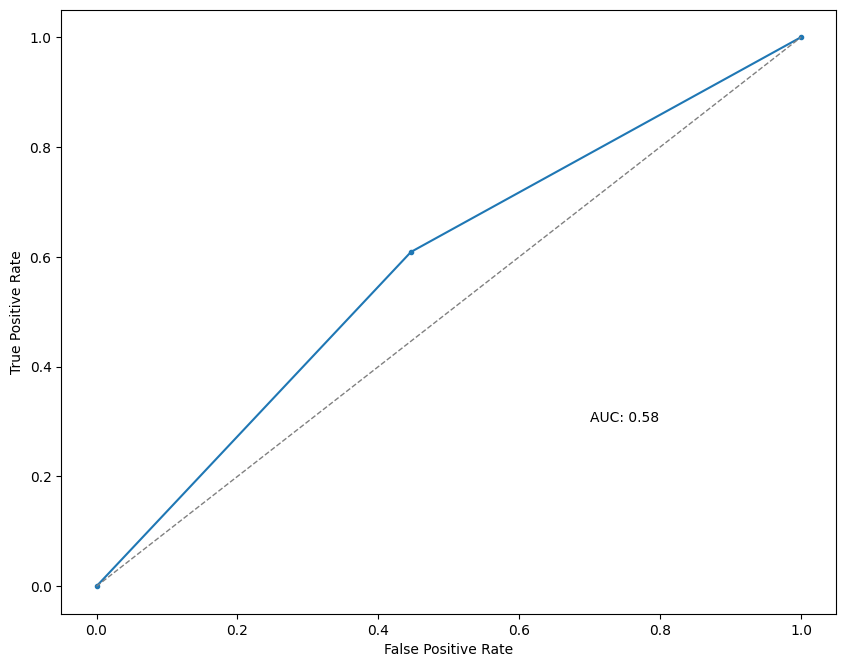

In [ ]:
DT = DecisionTreeClassifier()
print(X_train)
DT.fit(X_train, y_train)
# column 0 is healthy
# column 1 is cancer
y_test_prob = DT.predict_proba(X_test)[:,1]
#y_test = y_test+1
#print(y_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = roc_auc_score(y_test, y_test_prob)

plt.clf()
plt.plot(fpr, tpr, "b-", lw=2, label="AUROC = %0.2f"%roc_auc)
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC {attributes["dataset"]}')
plt.legend(loc="best")
#plt.savefig("roc_curve.png",bbox_inches='tight', dpi=300)

def cross_validate(model, X_input, Y_output):
    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    y = np.array([0] * X_input.shape[0])
    yh = np.array([0.0] * X_input.shape[0])
    for train_index, test_index in kf.split(X_input):
        model.fit(X_input[train_index], Y_output[train_index])
        y[test_index] = Y_output[test_index]
        yh[test_index] = model.predict_proba(X_input[test_index])[:,1]
    return y, yh

DT = DecisionTreeClassifier()

true_labels,pred_scores = cross_validate(DT, X, y)

print(true_labels)
fpr, tpr, _ = roc_curve(true_labels, pred_scores)
auc = roc_auc_score(true_labels, pred_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color='gray')
plt.text(0.7, 0.3, 'AUC: '+str(round(auc,2)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.savefig('prostate_cancer_knn_crossvalid_roc.eps')